In [248]:
!pip install faiss-cpu


In [249]:
import numpy as np
from scipy import spatial
import faiss
from time import time
import matplotlib.pyplot as plt
from collections import defaultdict
import random

## Helper Function

In [250]:
def semi_optimized_exhaustive_search(
        index_vectors: np.ndarray,
        query_vectors: np.ndarray,
        k: int,
):
    """
    This function performs an optimized exhaustive search.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        dim: The dimensionality of the vectors.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k nearest neighbors for each query vector.
    """
    ann_lists = []
    for query_vec in query_vectors:
        distances = np.linalg.norm(index_vectors - query_vec, axis=1)
        ann_lists.append(list(np.argsort(distances)[:k]))
    return np.array(ann_lists)

In [251]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors.
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

In [252]:
def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (, ) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances, indices = index.search(query_vectors, k)
    return indices

In [253]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors.
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

In [254]:
def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

In [255]:
import numpy as np

def initialize_centers(index_vectors: np.ndarray, k: int) -> np.ndarray:
    """
    Initialize k cluster centers randomly from the data points.

    Parameters:
    index_vectors (np.ndarray): The data to cluster.
    k (int): The number of clusters.

    Returns:
    np.ndarray: The initialized cluster centers.
    """
    indices = np.random.choice(index_vectors.shape[0], k, replace=False)
    return index_vectors[indices]

def assign_clusters(index_vectors: np.ndarray, centers: np.ndarray) -> np.ndarray:
    """
    Assign each data point to the nearest cluster center.

    Parameters:
    index_vectors (np.ndarray): The data to cluster.
    centers (np.ndarray): The current cluster centers.

    Returns:
    np.ndarray: The cluster labels for each data point.
    """
    distances = np.linalg.norm(index_vectors[:, np.newaxis] - centers, axis=2)
    return np.argmin(distances, axis=1)

def update_centers(index_vectors: np.ndarray, labels: np.ndarray, k: int) -> np.ndarray:
    """
    Update the cluster centers as the mean of the assigned data points.

    Parameters:
    index_vectors (np.ndarray): The data to cluster.
    labels (np.ndarray): The current cluster labels for each data point.
    k (int): The number of clusters.

    Returns:
    np.ndarray: The updated cluster centers.
    """
    centers = np.zeros((k, index_vectors.shape[1]))
    for i in range(k):
        points = index_vectors[labels == i]
        if len(points) > 0:
            centers[i] = np.mean(points, axis=0)
    return centers

def run_kmeans(index_vectors: np.ndarray, k: int, max_iters: int = 10, tol: float = 1e-4):
    """
    Run KMeans clustering on the given index vectors.

    Parameters:
    index_vectors (np.ndarray): The data to cluster, where each row is an index vector.
    k (int): The number of clusters.
    max_iters (int): Maximum number of iterations.
    tol (float): Tolerance for convergence.

    Returns:
    tuple: A tuple containing:
        - labels (np.ndarray): The cluster labels for each index vector.
        - centers (np.ndarray): The coordinates of the cluster centers.
    """
    centers = initialize_centers(index_vectors, k)
    for _ in range(max_iters):
        labels = assign_clusters(index_vectors, centers)
        new_centers = update_centers(index_vectors, labels, k)

        if np.linalg.norm(new_centers - centers) < tol:
            break

        centers = new_centers

    return labels, centers


class KMindex:
    def __init__(self, labels, centers, index_vectors):
        """
        Parameters:
        labels (np.ndarray): The cluster labels for each index vector.
        centers (np.ndarray): The coordinates of the cluster centers.
        index_vectors (np.ndarray): The original index vectors.
        """
        self.labels = labels
        self.centers = centers
        self.index_vectors = index_vectors

    def search(self, query_vectors, k=1):
        """
        Parameters:
        query_vectors (np.ndarray): The query vectors to search for.
        k (int): The number of nearest neighbors to return.

        Returns:
        indices (np.ndarray): The indices of the nearest neighbors for each query vector.
        """
        distances_to_centers = self.compute_distances_to_centers(query_vectors)
        nearest_centers = np.argmin(distances_to_centers, axis=1)
        ann_lists = self.find_nearest_neighbors(query_vectors, nearest_centers, distances_to_centers, k)
        return np.array(ann_lists)

    def compute_distances_to_centers(self, query_vectors):
        """
        Compute the distances from query vectors to cluster centers.

        Parameters:
        query_vectors (np.ndarray): The query vectors.

        Returns:
        np.ndarray: The distances from query vectors to cluster centers.
        """
        return np.linalg.norm(query_vectors[:, np.newaxis] - self.centers, axis=2)

    def find_nearest_neighbors(self, query_vectors, nearest_centers, distances_to_centers, k):
        """
        Find the nearest neighbors for each query vector.

        Parameters:
        query_vectors (np.ndarray): The query vectors.
        nearest_centers (np.ndarray): The indices of the nearest cluster centers for each query vector.
        distances_to_centers (np.ndarray): The distances from query vectors to cluster centers.
        k (int): The number of nearest neighbors to return.

        Returns:
        list: A list of indices of the nearest neighbors for each query vector.
        """
        ann_lists = []
        for i, query_vec in enumerate(query_vectors):
            ann_lists.append(self.find_neighbors_in_cluster(query_vec, nearest_centers[i], distances_to_centers[i], k))
        return ann_lists

    def find_neighbors_in_cluster(self, query_vec, cluster_label, distances_to_centers_row, k):
        """
        Find the nearest neighbors within a cluster or across multiple clusters if needed.

        Parameters:
        query_vec (np.ndarray): A single query vector.
        cluster_label (int): The label of the nearest cluster.
        distances_to_centers_row (np.ndarray): The distances from the query vector to cluster centers.
        k (int): The number of nearest neighbors to return.

        Returns:
        np.ndarray: The indices of the nearest neighbors.
        """
        cluster_indices = np.where(self.labels == cluster_label)[0]
        cluster_vectors = self.index_vectors[cluster_indices]

        if len(cluster_vectors) < k:
            nearest_indices = self.handle_insufficient_cluster_size(query_vec, cluster_indices, cluster_vectors, distances_to_centers_row, k)
        else:
            nearest_indices = self.find_nearest_in_cluster(query_vec, cluster_indices, cluster_vectors, k)

        return nearest_indices

    def handle_insufficient_cluster_size(self, query_vec, cluster_indices, cluster_vectors, distances_to_centers_row, k):
        """
        Handle the case where the closest cluster has fewer than k vectors.

        Parameters:
        query_vec (np.ndarray): A single query vector.
        cluster_indices (np.ndarray): The indices of vectors in the closest cluster.
        cluster_vectors (np.ndarray): The vectors in the closest cluster.
        distances_to_centers_row (np.ndarray): The distances from the query vector to cluster centers.
        k (int): The number of nearest neighbors to return.

        Returns:
        np.ndarray: The indices of the nearest neighbors.
        """
        remaining_k = k - len(cluster_vectors)
        nearest_indices_within_cluster = self.find_nearest_in_cluster(query_vec, cluster_indices, cluster_vectors, len(cluster_vectors))

        second_closest_cluster_label = np.argsort(distances_to_centers_row)[1]
        second_cluster_indices = np.where(self.labels == second_closest_cluster_label)[0]
        second_cluster_vectors = self.index_vectors[second_cluster_indices]

        nearest_indices_within_second_cluster = self.find_nearest_in_cluster(query_vec, second_cluster_indices, second_cluster_vectors, remaining_k)

        return np.concatenate([nearest_indices_within_cluster, nearest_indices_within_second_cluster])

    def find_nearest_in_cluster(self, query_vec, cluster_indices, cluster_vectors, k):
        """
        Find the nearest neighbors within a given cluster.

        Parameters:
        query_vec (np.ndarray): A single query vector.
        cluster_indices (np.ndarray): The indices of vectors in the cluster.
        cluster_vectors (np.ndarray): The vectors in the cluster.
        k (int): The number of nearest neighbors to return.

        Returns:
        np.ndarray: The indices of the nearest neighbors.
        """
        distances = np.linalg.norm(cluster_vectors - query_vec, axis=1)
        return cluster_indices[np.argsort(distances)[:k]]




# 2.1 -- LSH vs Naive Exhaustive Search (Regular Index Vectors)
### You just have to run the following cells and add the following results to the report:
* running time of the ground truth computation with semi_optimized_exhaustive_search (wall time)
* running time of creating faiss_lsh_index (wall time)
* running time of faiss_search over query_vectors with faiss_lsh_index (wall time)
* recall@10 for faiss_lsh_ann

In [256]:
query_vectors = np.load('query_vectors.npy')
index_vectors = np.load('index_vectors.npy')
k=10
dim = index_vectors.shape[1]

In [257]:
%%time
gt_nn = semi_optimized_exhaustive_search(index_vectors, query_vectors, k)

CPU times: user 12.2 s, sys: 20.4 ms, total: 12.2 s
Wall time: 16.7 s


In [258]:
%%time
faiss_lsh_index = build_faiss_lsh_index(index_vectors, dim, nbits=2000)

CPU times: user 1.35 s, sys: 102 ms, total: 1.46 s
Wall time: 1.57 s


In [259]:
%%time
faiss_lsh_ann = faiss_search(query_vectors, faiss_lsh_index, k)

CPU times: user 1.32 s, sys: 0 ns, total: 1.32 s
Wall time: 977 ms


In [260]:
print(f"recall@10 for faiss_lsh_index: {compute_recall_at_k(gt_nn, faiss_lsh_ann, k)}")

recall@10 for faiss_lsh_index: 0.138


# 2.2 -- Custom Indexing Algorithm
Build an indexing algorithm that satisfies the following requirements:
* The indexing algorithm should be able to handle vectors of different dimensions
* The running time of the indexing should be less than half of the running time of semi_optimized_exhaustive_search), reported in Section 2.1.
* The running time of searching over the index should be less than a third (1/3) of the time of the semi_optimized_exhaustive_search function, reported in Section 2.1.
* The performance (in terms of recall@10) of the indexing algorithm should be at least 0.8.

The last three bullets should also appear in the report.
You are allowed to add as many helper functions as you need. You cannot use faiss of scipy libraries for this task. Numpy is allowed.

You can also test your algorithm with the additional two query-index sets by replacing the calls made few cells ago to:

    query_vectors = np.load('data/query_vectors2.npy')
    index_vectors = np.load('data/index_vectors2.npy')
or:

    query_vectors = np.load('data/query_vectors3.npy')
    index_vectors = np.load('data/index_vectors3.npy')
    
the aforementioned requirements should also be satisfied over these two query-index sets. No need to insert the results over these two to the report.

In [261]:
#TODO: Write your code for 2.2.2 here
# You are allowed to add more arguments to the functions and create more functions if needed.

def custom_indexing_algorithm(index_vectors, dim,clusters):
    """
    This function builds an index from scratch.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors.
        clusters: The number of clusters.
    Returns:
        An index.
    """
    labels, centers = run_kmeans(index_vectors, clusters)
    index = KMindex(labels, centers, index_vectors)
    return index


def custom_index_search(query_vectors, index, k):
    """
    This function searches over the custom index.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        index: The custom index.
        k: The number of nearest neighbors to retrieve.
    """
    return index.search(query_vectors, k)


In [262]:
# Add hyperparameters here (if needed)

In [263]:
%%time
clusters = 9
custom_index = custom_indexing_algorithm(index_vectors, dim,clusters)

CPU times: user 297 ms, sys: 345 ms, total: 642 ms
Wall time: 686 ms


In [264]:
%%time
custom_index_ann = custom_index_search(query_vectors, custom_index, k)

CPU times: user 2.24 s, sys: 7.02 ms, total: 2.25 s
Wall time: 3.03 s


In [265]:
print(f"recall@10 for custom_index_search: {compute_recall_at_k(gt_nn, custom_index_ann, k)}")

recall@10 for custom_index_search: 1.0


**Compute K**

In [266]:
import time

start_time = time.time()
gt_nn = semi_optimized_exhaustive_search(index_vectors, query_vectors, k)
end_time = time.time()
baseline_time = end_time - start_time
min_recall = 0.8
max_indexing_time = baseline_time*0.5
max_search_time = baseline_time*0.33
print("Baseline walltime time:", baseline_time)
print(f'Maximum indexing time: {max_indexing_time}')
print(f'Maximum search time: {max_search_time}')
print(f'Minimum recall@10: {min_recall}')

Baseline walltime time: 17.61409068107605
Maximum indexing time: 8.807045340538025
Maximum search time: 5.812649924755097
Minimum recall@10: 0.8


In [267]:
from re import search

def compute_indexing_time(index_vectors, dim,clusters):
  start_time = time.time()
  custom_index = custom_indexing_algorithm(index_vectors, dim,clusters)
  end_time = time.time()
  indexing_time = end_time - start_time
  return indexing_time,custom_index


def compute_search_time(query_vectors, custom_index, k):
  start_time = time.time()
  custom_index_ann = custom_index_search(query_vectors, custom_index, k)
  end_time = time.time()
  search_time = end_time - start_time
  return search_time, custom_index_ann


def plot_graphs(index_vectors, dim, max_indexing_time, min_recall, max_search_time):
  clusters = [i*4 for i in range(1, 15)]
  indexing_times = []
  search_times = []
  recall_values = []
  for cluster_num in clusters:
    indexing_time, custom_index = compute_indexing_time(index_vectors, dim,cluster_num)
    indexing_times.append(indexing_time)
    search_time, custom_index_ann = compute_search_time(query_vectors, custom_index, k)
    search_times.append(search_time)
    recall = compute_recall_at_k(gt_nn, custom_index_ann, k)
    recall_values.append(recall)

  plt.plot(clusters, indexing_times)
  plt.axhline(y=max_indexing_time, color='r', linestyle='--', label='max_indexing_time')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Indexing Time (seconds)')
  plt.title('Indexing Time vs Number of Clusters')
  plt.legend()
  plt.show()
  print()

  plt.plot(clusters, search_times)
  plt.axhline(y=max_search_time, color='r', linestyle='--', label='max_search_time')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Search Time (seconds)')
  plt.title('Search Time vs Number of clusters')
  plt.legend()
  plt.show()
  print()

  plt.plot(clusters, recall_values)
  plt.axhline(y=min_recall, color='r', linestyle='--', label='min_recall@10')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Recall@10')
  plt.title('Recall@10 vs Number of Clusters')
  plt.legend()
  plt.show()


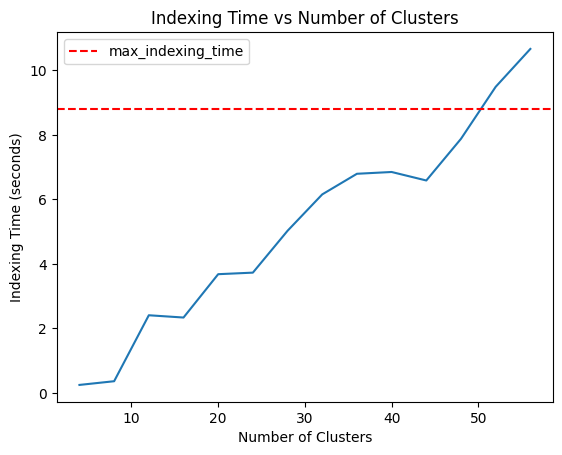

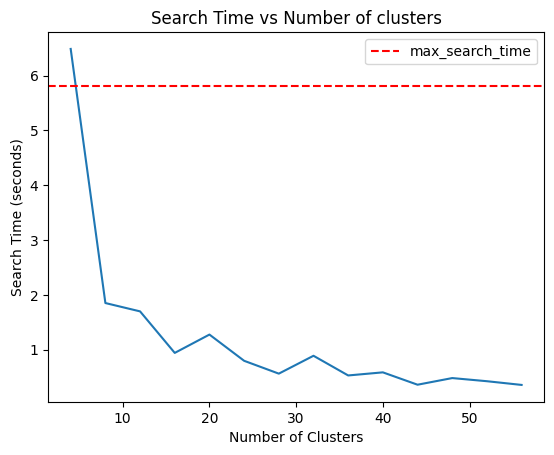

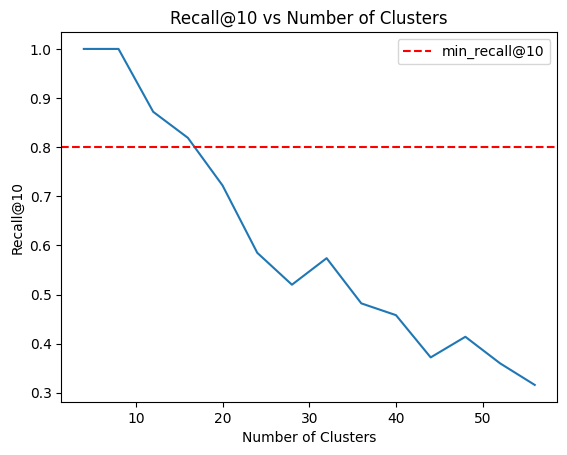

In [268]:
plot_graphs(index_vectors, dim, max_indexing_time, min_recall, max_search_time)

**Ensure results on datasets 2 and 3**

In [269]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Data_num", "Exhaustive_time", "Indexing_time", "Search_time", "Recall"]

for i in [2,3]:
  query_vectors = np.load(f'query_vectors{i}.npy')
  index_vectors = np.load(f'index_vectors{i}.npy')
  dim = index_vectors.shape[1]
  k = 10
  clusters = 9
  gt_nn = semi_optimized_exhaustive_search(index_vectors, query_vectors, k)
  indexing_time, custom_index = compute_indexing_time(index_vectors, dim,clusters)
  search_time, custom_index_ann = compute_search_time(query_vectors, custom_index, k)
  recall = compute_recall_at_k(gt_nn, custom_index_ann, k)
  table.add_row([i, baseline_time, indexing_time, search_time, recall])

print(table)

+----------+-------------------+--------------------+--------------------+--------+
| Data_num |  Exhaustive_time  |   Indexing_time    |    Search_time     | Recall |
+----------+-------------------+--------------------+--------------------+--------+
|    2     | 17.61409068107605 | 0.8165304660797119 | 2.9334967136383057 |  1.0   |
|    3     | 17.61409068107605 | 0.4681084156036377 | 1.729466199874878  |  1.0   |
+----------+-------------------+--------------------+--------------------+--------+
